## Installation for GLIGEN

In [ ]:
!pip install transformers accelerate scipy safetensors
!git clone https://github.com/gligen/diffusers.git
!pip install git+https://github.com/gligen/diffusers.git
# Installation for GroundingDINO
%cd /content
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd /content/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

fatal: destination path 'diffusers' already exists and is not an empty directory.
  Cloning https://github.com/gligen/diffusers.git to /tmp/pip-req-build-8j536mu0
  Running command git clone --filter=blob:none --quiet https://github.com/gligen/diffusers.git /tmp/pip-req-build-8j536mu0
  Resolved https://github.com/gligen/diffusers.git to commit 0e09db9d7150126e327ff93cf91857b00f624ee0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content
fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done


In [ ]:
# Download image for the test

import os
if not os.path.exists('/content/art_dog_birthdaycake.png'):
    %cd /content
    !wget https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/art_dog_birthdaycake.png

## Import Libraries

In [ ]:
import argparse
from functools import partial
import cv2
import requests

from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path
import random

import warnings
warnings.filterwarnings("ignore")

import torch
from torchvision.ops import box_convert

from groundingdino.models import build_model
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict
from groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T

from huggingface_hub import hf_hub_download

## Utils functions

These functions were originally presented in [this articale](https://medium.com/@tatsuromurata317/gligen-diffusers-f8587be28d8c)

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
def prepare_boundings(path: str, objects: list):
    text_prompt = ''
    for object in objects:
        text_prompt += f'{object}. '
    box_threshold = 0.35
    text_threshold = 0.25

    image_source, image = load_image(path)

    boxes, logits, phrases = predict(
        model=dino_model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

    return image_source, image, annotated_frame, boxes

In [ ]:
def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

In [ ]:
def gligen_inpainting(path, new_objects, objects):
    print('#' * 88)
    print('Boundings preparation...')
    image_source, image, annotated_frame, boxes = prepare_boundings(path=path, objects=objects)

    print('#' * 88)
    print('Generating masks...')
    image_mask = generate_masks_with_grounding(image_source, boxes)
    display(Image.fromarray(annotated_frame))

    print('#' * 88)
    print('Inpainting...')
    image_source = Image.fromarray(image_source)
    annotated_frame = Image.fromarray(annotated_frame)
    image_mask = Image.fromarray(image_mask)
    # Resize
    image_source_for_inpaint = image_source.resize((512, 512))
    image_mask_for_inpaint = image_mask.resize((512, 512))
    # Get bbox
    xyxy_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").tolist()

    # Define prompts for each box
    gligen_phrases  = []
    prompt = ""
    for i, object in enumerate(new_objects):
        gligen_phrases.append(object)
        prompt += f"{object}"
        if i != len(new_objects) - 1:
            prompt += ', '

    print(f'gligen_phrases: {gligen_phrases}')
    print(f'prompt: {prompt}')
    num_box = len(boxes)

    image_inpainting = inpainting_pipe(
        prompt,
        num_images_per_prompt = 4,
        gligen_phrases = gligen_phrases,
        gligen_inpaint_image = image_source_for_inpaint,
        gligen_boxes = xyxy_boxes,
        gligen_scheduled_sampling_beta=1,
        output_type="numpy",
        num_inference_steps=50
    ).images

    image_inpainting = (image_inpainting * 255).astype(np.uint8)
    image_inpainting = np.concatenate(image_inpainting, axis=1)

    print('#' * 88)

    return image_inpainting, image_source

## GLIGEN Image Inpainting

### Load detection model and gligen model

In [ ]:
# Load detection model
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swint_ogc.pth"
ckpt_config_filename = "GroundingDINO_SwinT_OGC.cfg.py"
dino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [ ]:
# Load gligen pipeline
from diffusers import StableDiffusionGLIGENPipeline

inpainting_pipe = StableDiffusionGLIGENPipeline.from_pretrained("gligen/diffusers-inpainting-text-box", revision="fp16", torch_dtype=torch.float16)
inpainting_pipe.to("cuda")

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionGLIGENPipeline {
  "_class_name": "StableDiffusionGLIGENPipeline",
  "_diffusers_version": "0.15.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Image Inpainting Inference


In [ ]:
PATH = '/content/art_dog_birthdaycake.png' # Path to the base picture
NEW_OBJECTS = ['a cat', 'a baguette'] # New objects which should replace old ones
OBJECTS = ['dog', 'cake'] # Existing objects to be replaced

########################################################################################
Boundings preparation...
########################################################################################
Generating masks...


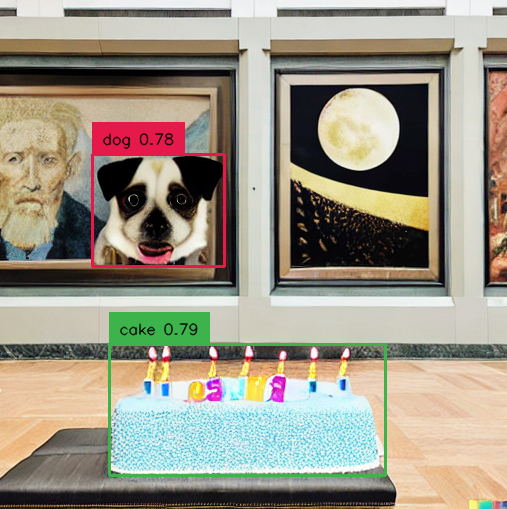

########################################################################################
Inpainting...
gligen_phrases: ['a cat', 'a baguette']
prompt: a cat, a baguette


  0%|          | 0/50 [00:00<?, ?it/s]

########################################################################################


In [ ]:
image_inpainting, image_source = gligen_inpainting(path=PATH, new_objects=NEW_OBJECTS, objects=OBJECTS)

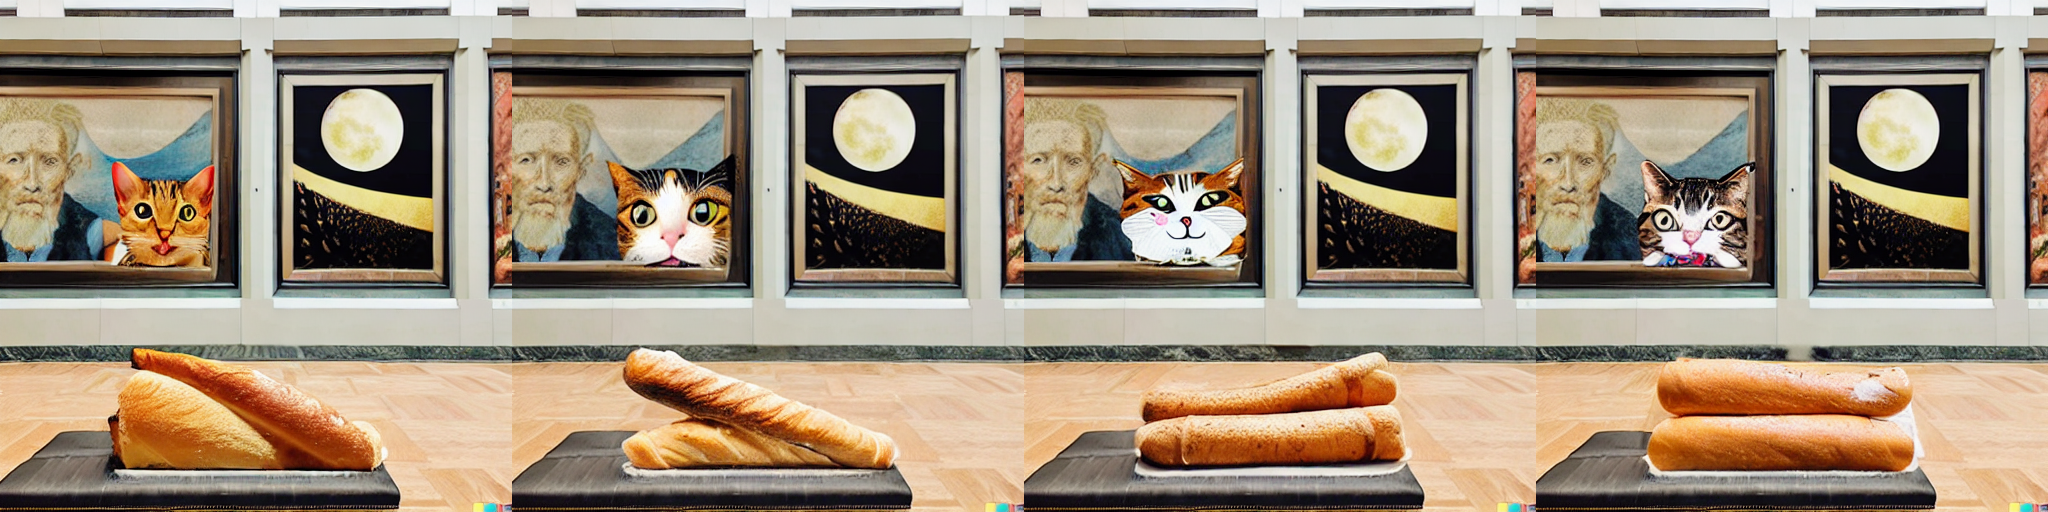

In [ ]:
# Display image
Image.fromarray(image_inpainting)